In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Global Settings**

In [ ]:
# Name of the directory on Google Drive for saving training log, loss/mAP chart,
# and weights
SAVE_DIR = 'yolov4_training'

# Path of the Google Drive mount point
DRIVE_DIR = '/content/drive/My Drive'

# Full path to the save directory on Google Drive
DRIVE_SAVE_DIR = DRIVE_DIR + '/' + SAVE_DIR

# Input shape {width}*{height} of the yolov4 model to be trained
# INPUT_SHAPE = '416x416'

In [ ]:
!rm -rf /content/data
!mkdir /content/data

Check and make sure Google Drive has been mounted before proceeding.

In [ ]:
from pathlib import Path
assert Path(DRIVE_DIR).is_dir(), 'Google Drive has not been mounted?'

**GPU Runtime**

Let's do a quick check which GPU has been allocated.

According to [Google Colab FAQ](https://research.google.com/colaboratory/faq.html#gpu-availability), "the GPUs available in Colab often include Nvidia K80s, T4s, P4s and P100s."  You should look for the "Name" field in nvidia-smi output below to see which GPU is used for this session.

In [ ]:
!nvidia-smi

Sun Jan 16 10:12:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd /content

!cp /content/drive/MyDrive/Training\ Items/obj.data data/
!cp /content/drive/MyDrive/Training\ Items/obj.names data/
!cp /content/drive/MyDrive/Training\ Items/test.txt data/
!cp /content/drive/MyDrive/Training\ Items/train.txt data/
!cp /content/drive/MyDrive/Training\ Items/yolov4-custom.cfg data/

!cp /content/drive/MyDrive/Training\ Items/prepare_data.sh data/
!cp /content/drive/MyDrive/Training\ Items/prepare_training.sh /content/

/content


In [ ]:
!cp /content/drive/MyDrive/yolov4_training/backup/yolov4-custom_last.weights data/

In [ ]:
%cd /content/data/
!chmod 755 prepare_data.sh
!./prepare_data.sh

Streaming output truncated to the last 5000 lines.
  inflating: Data/img775.jpg         
  inflating: Data/img775.txt         
  inflating: Data/img7750.jpg        
  inflating: Data/img7750.txt        
  inflating: Data/img7751.jpg        
  inflating: Data/img7751.txt        
  inflating: Data/img7752.jpg        
  inflating: Data/img7752.txt        
  inflating: Data/img7753.jpg        
  inflating: Data/img7753.txt        
  inflating: Data/img7754.jpg        
  inflating: Data/img7754.txt        
  inflating: Data/img7755.jpg        
  inflating: Data/img7755.txt        
  inflating: Data/img7756.jpg        
  inflating: Data/img7756.txt        
  inflating: Data/img7757.jpg        
  inflating: Data/img7757.txt        
  inflating: Data/img7758.jpg        
  inflating: Data/img7758.txt        
  inflating: Data/img7759.jpg        
  inflating: Data/img7759.txt        
  inflating: Data/img776.jpg         
  inflating: Data/img776.txt         
  inflating: Data/img7760.jpg        

**Step 3**

Check out "darknet" source code from GitHub.

In [ ]:
%cd /content/
!rm -rf data/objs
!rm -rf darknet
!git clone https://github.com/AlexeyAB/darknet.git

/content
Cloning into 'darknet'...
remote: Enumerating objects: 15395, done.
remote: Total 15395 (delta 0), reused 0 (delta 0), pack-reused 15395
Receiving objects: 100% (15395/15395), 14.02 MiB | 24.96 MiB/s, done.
Resolving deltas: 100% (10352/10352), done.


**Step 4**

Patch darknet source code and build executable.  Note the following CUDA arch settings in the patch:

* "37": Tesla K80
* "60": Tesla P100
* "61": Tesla P4
* "75": Tesla T4

In [ ]:
%cd /content/darknet
!sed -i "1s/GPU=0/GPU=1/"               Makefile
!sed -i "2s/CUDNN=0/CUDNN=1/"           Makefile
!sed -i "3s/CUDNN_HALF=0/CUDNN_HALF=1/" Makefile
!sed -i "4s/OPENCV=0/OPENCV=1/"         Makefile
!sed -i "5s/AVX=0/AVX=1/"               Makefile
!sed -i "7s/LIBSO=0/LIBSO=1/"           Makefile
!sed -i "20s/compute_30,code=sm_30 \\\/compute_37,code=sm_37 -gencode arch=compute_60,code=[sm_60,compute_60] -gencode arch=compute_61,code=[sm_61,compute_61] -gencode arch=compute_75,code=[sm_75,compute_75]/" Makefile
!sed -i "21s/^/#/"                      Makefile
!sed -i "22s/^/#/"                      Makefile
!sed -i "23s/^/#/"                      Makefile
!sed -i "24s/^/#/"                      Makefile
# Let darknet test mAP more frequently during training 
!sed -i "300s/calc_map_for_each = 4/calc_map_for_each = 1/" src/detector.c

!make

/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -ffp-contract=fast -mavx -mavx2 -msse3 -msse4.1 -msse4.2 -msse4a -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ cla

## For CPU

In [ ]:
%cd /content/darknet
#!sed -i "1s/GPU=0/GPU=1/"               Makefile
#!sed -i "2s/CUDNN=0/CUDNN=1/"           Makefile
#!sed -i "3s/CUDNN_HALF=0/CUDNN_HALF=1/" Makefile
!sed -i "4s/OPENCV=0/OPENCV=1/"         Makefile
!sed -i "5s/AVX=0/AVX=1/"               Makefile
!sed -i "7s/LIBSO=0/LIBSO=1/"           Makefile
!sed -i "20s/compute_30,code=sm_30 \\\/compute_37,code=sm_37 -gencode arch=compute_60,code=[sm_60,compute_60] -gencode arch=compute_61,code=[sm_61,compute_61] -gencode arch=compute_75,code=[sm_75,compute_75]/" Makefile
!sed -i "21s/^/#/"                      Makefile
!sed -i "22s/^/#/"                      Makefile
!sed -i "23s/^/#/"                      Makefile
!sed -i "24s/^/#/"                      Makefile
# Let darknet test mAP more frequently during training 
!sed -i "300s/calc_map_for_each = 4/calc_map_for_each = 1/" src/detector.c

!make

**Step 5**

Create folders and symlinks for saving training log and results.

In [ ]:
!mkdir -p "{DRIVE_SAVE_DIR}"
!touch "{DRIVE_SAVE_DIR}"/train.log
!rm -f train.log
!ln -sf "{DRIVE_SAVE_DIR}"/train.log .
!touch "{DRIVE_SAVE_DIR}"/chart.png
!rm -f chart.png
!ln -sf "{DRIVE_SAVE_DIR}"/chart.png .
!mkdir -p "{DRIVE_SAVE_DIR}"/backup
!rm -rf backup
!ln -sf "{DRIVE_SAVE_DIR}"/backup .

**Step 6**

Set up all remaining files needed for training the model.  The pre-trained yolov4 weights file ("yolov4.conv.137") is also downloaded here.

In [ ]:
%cd /content/
!chmod 755 prepare_training.sh
!./prepare_training.sh

!cp /content/data/yolov4-custom_last.weights darknet/backup/

/content
** Install requirements
** Copy files for training
** Download pre-trained yolov4 weights
Downloading...
From: https://drive.google.com/uc?id=1JKF-bdIklxOOVy-2Cr5qdvjgGpmGfcbp
To: /content/darknet/yolov4.conv.137
100% 170M/170M [00:01<00:00, 95.5MB/s]
** Done.


**Step 7**

Start training!  The total number of training iterations is 5,000.  It could take more than 3 hours to finish.

Training progress could be checked by looking at the following files on your Google Drive:

   ```
   yolov4_crowdhuman/train.log
   yolov4_crowdhuman/chart.png
   ```

In [ ]:
%cd /content/darknet
!./darknet detector train data/obj.data cfg/yolov4-custom.cfg backup/yolov4-custom_last.weights -gpus 0 -map -dont_show 2>&1 | tee "{DRIVE_SAVE_DIR}"/train.log | grep -E "hours left|mean_average"

/content/darknet
 (next mAP calculation at 5225 iterations) ]2;4501/17000: loss=1.3 hours left=-1.0
 4501: 1.275413, 1.275413 avg loss, 0.001000 rate, 10.274269 seconds, 288064 images, -1.000000 hours left
 (next mAP calculation at 5225 iterations) ]2;4502/17000: loss=1.7 hours left=35.7
 4502: 1.694796, 1.317351 avg loss, 0.001000 rate, 10.244753 seconds, 288128 images, 35.671865 hours left
 (next mAP calculation at 5225 iterations) ]2;4503/17000: loss=1.7 hours left=35.7
 4503: 1.685569, 1.354173 avg loss, 0.001000 rate, 10.419976 seconds, 288192 images, 35.670813 hours left
 (next mAP calculation at 5225 iterations) ]2;4504/17000: loss=1.2 hours left=35.7
 4504: 1.192912, 1.338047 avg loss, 0.001000 rate, 10.188381 seconds, 288256 images, 35.675826 hours left
 (next mAP calculation at 5225 iterations) ]2;4505/17000: loss=1.1 hours left=35.7
 4505: 1.074324, 1.311674 avg loss, 0.001000 rate, 10.356427 seconds, 288320 images, 35.672721 hours left
 (next mAP calculation at 52

In [ ]:
%cd /content/darknet
!./darknet detector train data/obj.data cfg/yolov4-custom.cfg yolov4.conv.137 -map -dont_show 2>&1 | tee "{DRIVE_SAVE_DIR}"/train.log | grep -E "hours left|mean_average"

/content/darknet
^C


**Step 8**

The trained "yolov4-crowdhuman-416x416" model (weights) is saved in the "yolov4_crowdhuman/backup/" directory on your Google Drive.

Let's test the "best" trained model.

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208

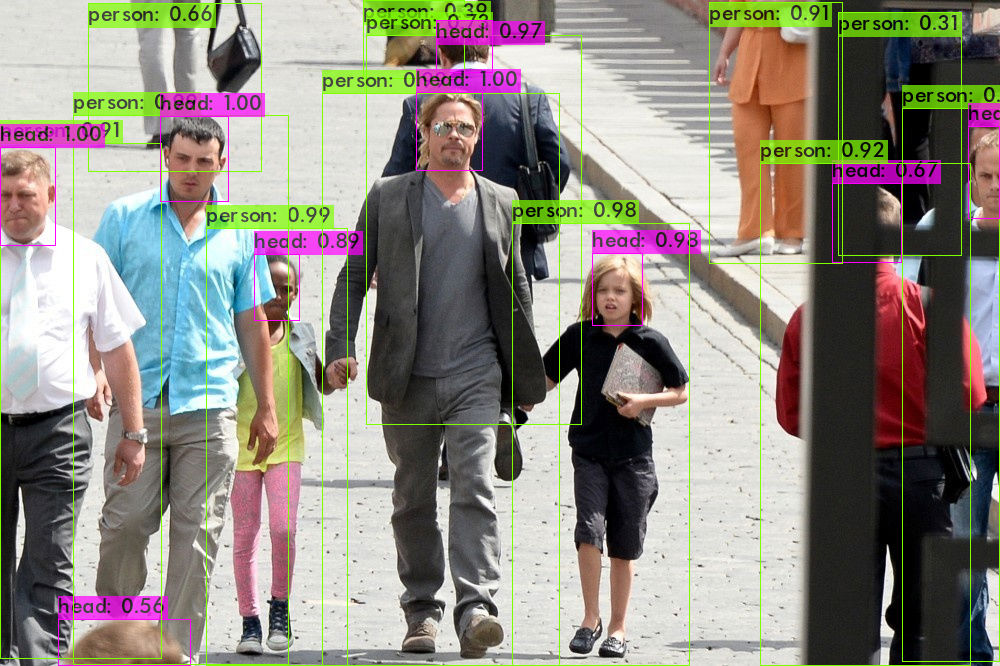

In [ ]:
!./darknet detector test data/crowdhuman-{INPUT_SHAPE}.data cfg/yolov4-crowdhuman-{INPUT_SHAPE}.cfg backup/yolov4-crowdhuman-{INPUT_SHAPE}_best.weights data/crowdhuman-{INPUT_SHAPE}/273275,4e9d1000623d182f.jpg -gpus 0 -dont_show

from IPython.display import Image
Image('predictions.jpg')

**Step 9**

For reference, I got a "yolov4-crowdhuman-416x416" model with mAP ~0.77.  Here's the loss/mAP chart.

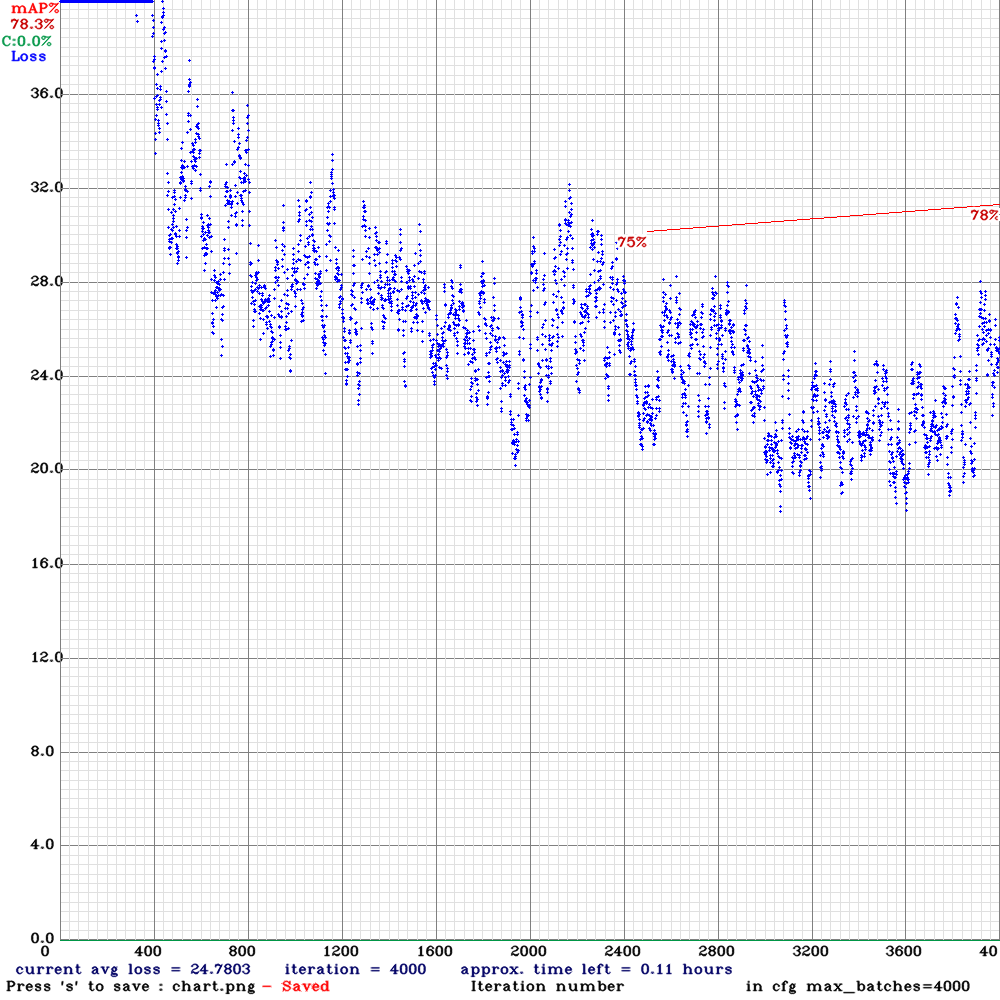

In [ ]:
Image('chart.png')

**All done.**

If possible, terminate the GPU session manually (for keeping a good record on Google Colab :-).